# League of Legends Professional Games Dataset 2015-2017
# EDA
# Michael Phillips

## Introduction

League of Legends (LoL) is a team-based, competitive online computer game. It is, by most accounts the most popular video game currently in active development. On September 13, 2016 the game’s developer, Riot Games, announced that their monthly active users topped 100 million. [Source](https://www.riftherald.com/2016/9/13/12865314/monthly-lol-players-2016-active-worldwide) 

Accompanying the main game, Riot sponsors a professional league made up of teams from around the world. The 2016 LoL World Championships were broadcast to online streaming platforms in 18 languages, with peak concurrent viewership (PCU) of 14.7 million people. Over 43 million unique visitors watched broadcasts during the tournament. The final prize pool for the Championship came out to 6.7 million dollars, split among the participating teams. [Source](http://www.lolesports.com/en_US/articles/2016-league-legends-world-championship-numbers)

I think there is a lot of room in the LoL community for in-depth data analysis, and am curious to see how the professional league evolves over the next several months and years. Riot has announced preliminary plans to franchise the team slots in their league during 2018, opening the door to increased sponsorship/revenues. 

Additionally, the broadcast revenue for the league will be split amongst the participating teams, much like the NFL and NBA currently do. These broadcast rights were recently sold to BAMTech, the streaming tech company owned by MLB and Disney, for a minimum of $300 million through 2023. [Source](https://www.engadget.com/2016/12/16/bamtech-riot-games-league-of-legends-streaming-deal-wsj/)

The data being examined here contains a wide variety of measurements from LoL Professional games spanning late 2014 to mid-2017. I will be hoping to gain a better understanding of what trends are present in the data, and to find potential areas of interest for the machine learning portion of this project. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

In [64]:
pk_df = pd.read_csv('player_kda.csv', index_col=0)
tk_df = pd.read_csv('team_kda.csv', index_col=0)
obj_df = pd.read_csv('object_sums.csv', index_col=0)
gen_df = pd.read_csv('merged_df.csv', index_col=0)
gm_df = pd.read_csv('gold_diff_merged.csv', index_col=0)
gt_df = pd.read_csv('gold_df_merged.csv', index_col=0)
kills_df = pd.read_csv('finals_kills3.csv')
gdf = pd.read_csv('gold_20.csv')

# Data Overview
## Total Wins, Losses, and Win Percentages

The most basic metrics include wins, losses and win percentages across the league. Let’s see which teams have consistently performed well.


In [4]:
results_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc=np.sum)
results_df = results_df.reset_index()
results_df.drop(['game_length', 'year'], inplace=True, axis=1)
results_df = results_df.rename(columns = {'result':'wins'})

In [5]:
# count of rows per team, will give total games
total_df = pd.pivot_table(gen_df, index=['team_name'], aggfunc='count')
total_df = total_df.reset_index()

cols = ['team_name', 'result']
total_df = total_df[cols]

# combine wins, total games df
wl_df = pd.merge(results_df, total_df, on='team_name')
wl_df = wl_df.rename(columns = {'result':'total_games'})

# find losses, win percentage
wl_df['losses'] = wl_df.total_games - wl_df.wins
wl_df['win_pct'] = wl_df.wins / wl_df.total_games
cols = ['team_name', 'wins', 'losses', 'total_games', 'win_pct']
wl_df = wl_df[cols]

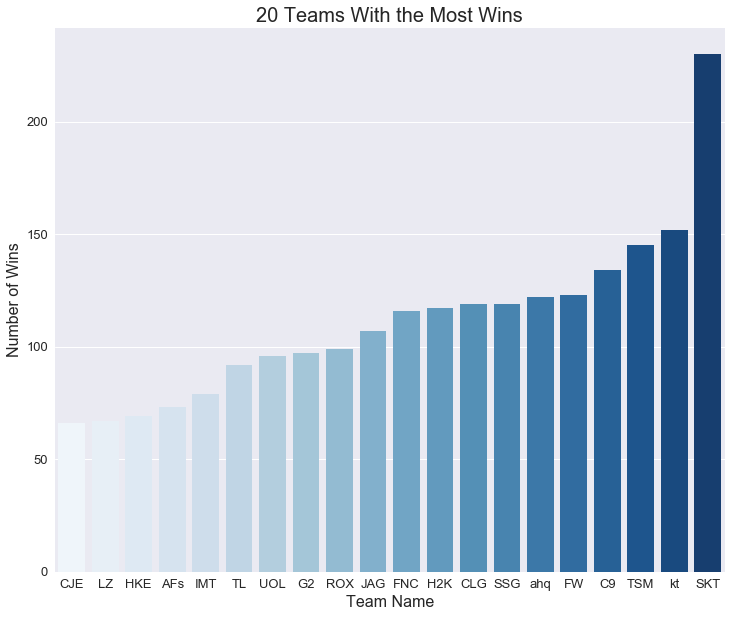

In [6]:
# sort wins for plotting
wins_df = wl_df[['team_name', 'wins']]
wins_df = wins_df.sort_values(by='wins')
wins_df = wins_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='wins', palette='Blues', data=wins_df);
plt.title("20 Teams With the Most Wins",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Number of Wins", fontsize=16);

SKT is legendary in the LoL professional league. The Korean team has won all three World Championships they have participated in. TSM and C9 also stand out as two of the most popular U.S. based teams. 

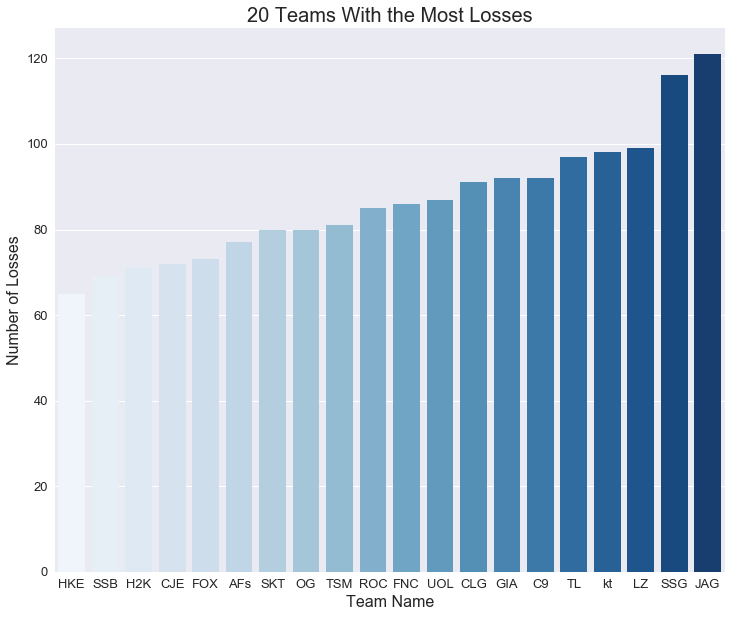

In [7]:
# sort losses for plotting
loss_df = wl_df[['team_name', 'losses']]
loss_df = loss_df.sort_values(by='losses')
loss_df = loss_df.tail(20)

# create plot
# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='losses', palette='Blues', data=loss_df);
plt.title("20 Teams With the Most Losses",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Number of Losses", fontsize=16);

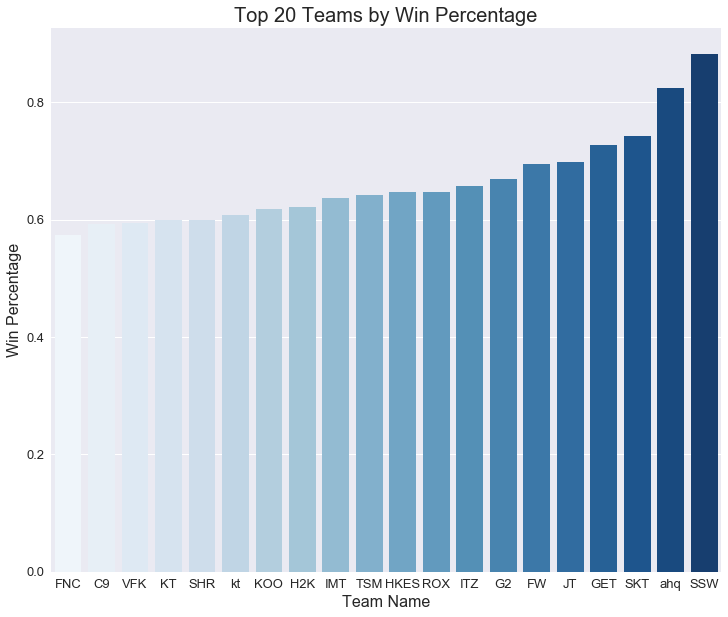

In [8]:
# sort losses for plotting
pct_df = wl_df[['team_name', 'win_pct']]
pct_df = pct_df.sort_values(by='win_pct')
pct_df = pct_df.tail(20)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='win_pct', palette='Blues', data=pct_df);
plt.title("Top 20 Teams by Win Percentage",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("Win Percentage", fontsize=16);

Win percentage is the best metric to see which teams perform well over the long run. SSW (Samsung White) is a since disbanded squad that had a strong run earlier in the game’s history. SKT and ahq are the best current teams. G2 is a recent addition to the European league.

## Bans

Bans take place during the pregame ‘draft’ period, when teams decide which Champion’s to play in the coming match. As previously noted there are ~140 Champions that can be picked. The bans are used to block the opposing team from choosing certain Champions. For years each team received three bans. Recently, this was upped to 5 bans per team.

One possible reason for the popularity of LoL could be the devotion Riot has to updating their game for balance and playability. The Champions are constantly being tweaked, upgraded, or otherwise altered. Because of this flux in how Champions are perceived by the community I will break bans down by year, and then look at overall numbers.


In [9]:
# prepare ban data split across 5 column for aggregation
bans = gen_df[['year', 'ban_1', 'ban_2', 'ban_3', 'ban_4', 'ban_5']]
bans2 = gen_df[['ban_1', 'ban_2', 'ban_3', 'ban_4', 'ban_5']]

bans2 = bans2.rename(columns = {'ban_1':'ban1',
                                'ban_2':'ban2',
                                'ban_3':'ban3',
                                'ban_4':'ban4',
                                'ban_5':'ban5',})
bans_df = bans.join(bans2)

In [10]:
# obtain counts for each champion ban
bans_pt = pd.pivot_table(bans_df, index=['year', 'ban_1'], values=['ban1'], aggfunc='count').reset_index()
bans_pt = bans_pt.rename(columns={'ban_1':'champion'})

bans_pt2 = pd.pivot_table(bans_df, index=['year', 'ban_2'], values=['ban2'], aggfunc='count').reset_index()
bans_pt2 = bans_pt2.rename(columns={'ban_2':'champion'})

bans_pt3 = pd.pivot_table(bans_df, index=['year', 'ban_3'], values=['ban3'], aggfunc='count').reset_index()
bans_pt3 = bans_pt3.rename(columns={'ban_3':'champion'})

bans_pt4 = pd.pivot_table(bans_df, index=['year', 'ban_4'], values=['ban4'], aggfunc='count').reset_index()
bans_pt4 = bans_pt4.rename(columns={'ban_4':'champion'})

bans_pt5 = pd.pivot_table(bans_df, index=['year', 'ban_5'], values=['ban5'], aggfunc='count').reset_index()
bans_pt5 = bans_pt5.rename(columns={'ban_5':'champion'})

# join to one dataframe and get sum
pt_merged = pd.merge(bans_pt, bans_pt2, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt3, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt4, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pd.merge(pt_merged, bans_pt5, how='outer', left_on=['year','champion'], right_on=['year','champion'])
pt_merged = pt_merged.fillna(0)
pt_merged['ban_sums'] = pt_merged.ban1 + pt_merged.ban2 + pt_merged.ban3 + pt_merged.ban4 + pt_merged.ban5
pt_merged = pt_merged[['year', 'champion', 'ban_sums']].sort_values(by=['year', 'ban_sums'])

In [11]:
# separate dataframes by year
df_14 = pt_merged.loc[pt_merged.year == 2014,:].tail(10)
df_15 = pt_merged.loc[pt_merged.year == 2015,:].tail(10)
df_16 = pt_merged.loc[pt_merged.year == 2016,:].tail(10)
df_17 = pt_merged.loc[pt_merged.year == 2017,:].tail(10)

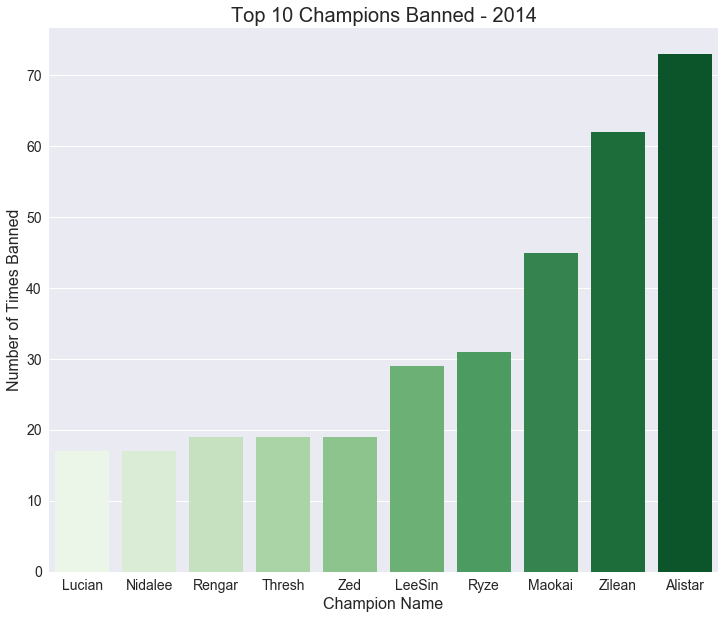

In [12]:
# create plot - most banned champion 2014
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette=('Greens'), data=df_14);
plt.title("Top 10 Champions Banned - 2014",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

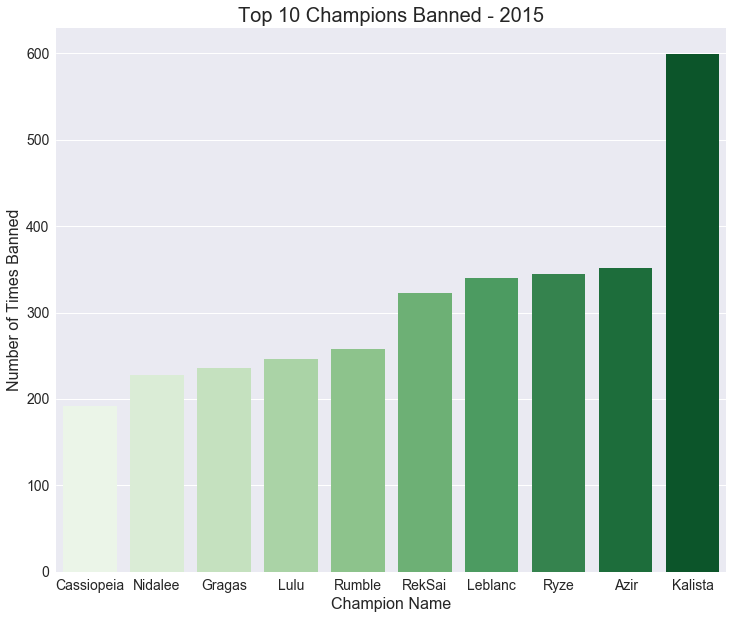

In [13]:
# create plot - most banned champion 2015
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_15);
plt.title("Top 10 Champions Banned - 2015",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

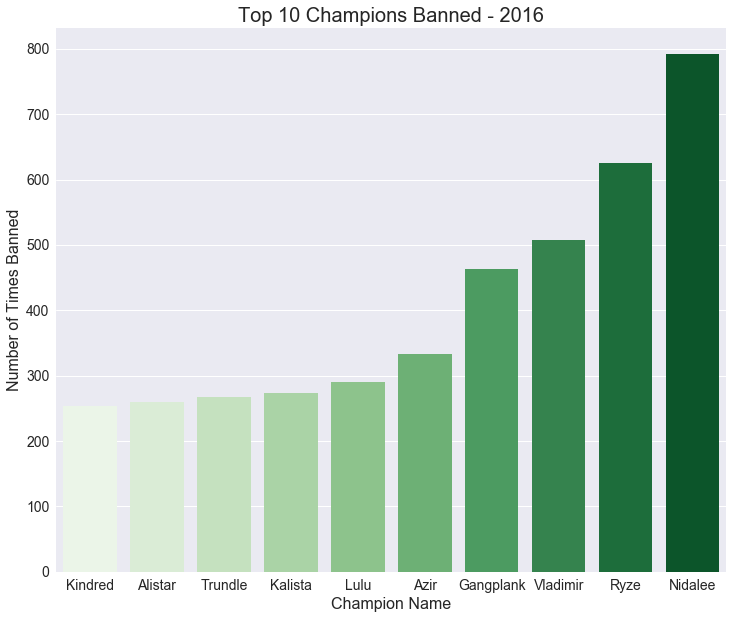

In [14]:
# create plot - most banned champion 2016
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_16);
plt.title("Top 10 Champions Banned - 2016",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

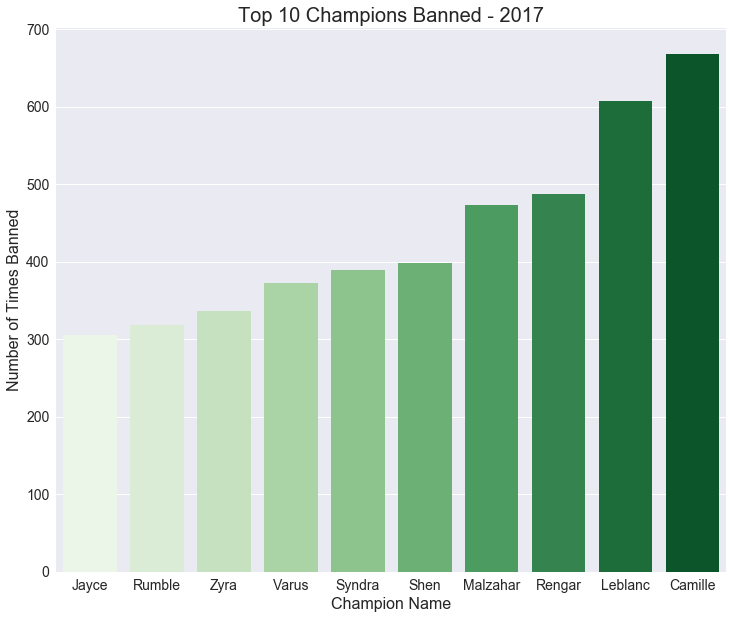

In [15]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='champion', y='ban_sums', palette='Greens', data=df_17);
plt.title("Top 10 Champions Banned - 2017",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Number of Times Banned", fontsize=16);

Ryze jumps out as appearing multiple times on these charts. Ryze is in an interesting Champion in that he builds his damage in an unconventional way, and has historically been very hard to balance correctly. Nidalee is another unique pick that can shapeshift and has access to more skills then most other Champions. Riot has moved her around the map several times, but always seems to come out either too strong or too weak.

## Kills, Deaths and Assists

One of the most basic measurements of how a team is doing in a given match is their ratio of kills to deaths. Kills and assists award gold which can be used to purchase powerful items. Deaths take a player out of the game for a certain amount of time, limiting the gold they can generate themselves. Kills can also allow the victorious team to take neutral objectives (discusses further down the report) which grant buffs as well as additional gold. 

Because KDA is such a useful metric for discussing LoL I will take a look at team-based scores, as well as individual player scores.

In [16]:
tk_pt = pd.pivot_table(tk_df, index=['team_name'], values=['kda_ratio'], aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')
tk_plot = tk_pt.tail(20)

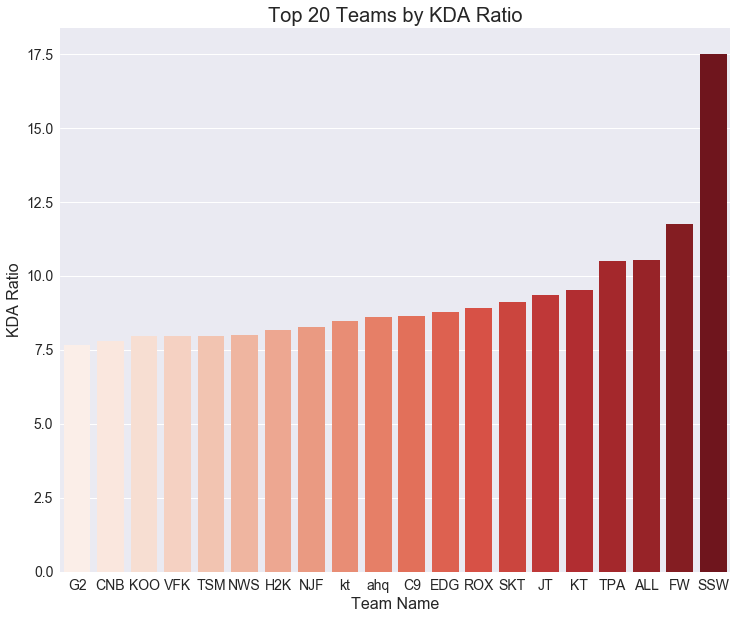

In [17]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='team_name', y='kda_ratio', palette='Reds', data=tk_plot);
plt.title("Top 20 Teams by KDA Ratio",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Team Name", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

SSW, ALL, and TPA are legacy teams from the game’s earlier days. SSW dominated the 2014 World Championships before disbanding, and their players moving to other squads. More recent entries on the chart are C9, EDG, and SKT. The gradual evening of the global talent-pool is evident from this chart as well. I don’t think it is possible for a team to achieve similar levels of success now, as SSW did a few years back.

## Individual players
First, I want to see which players have played the most games during the period the data covers.

In [18]:
# get number of games played
pk_pt2 = pd.pivot_table(pk_df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')
# players with the most games played
pk_pt2.tail(10)

,player,kda_ratio
287,Kuro,243
525,Ssumday,248
414,PraY,252
40,Arrow,259
205,GorillA,259
505,Smeb,260
480,Score,260
164,Faker,272
613,Wolf,298
52,Bang,310


Let's see which players have been particularly effective.

In [19]:
pk_pt = pd.pivot_table(pk_df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')
pk_merge = pd.merge(pk_pt2, pk_pt, on='player')
pk_merge = pk_merge.loc[pk_merge['kda_ratio_x'] >= 40,:]
pk_merge = pk_merge.sort_values(by='kda_ratio_y')
pk_plot = pk_merge.tail(20)

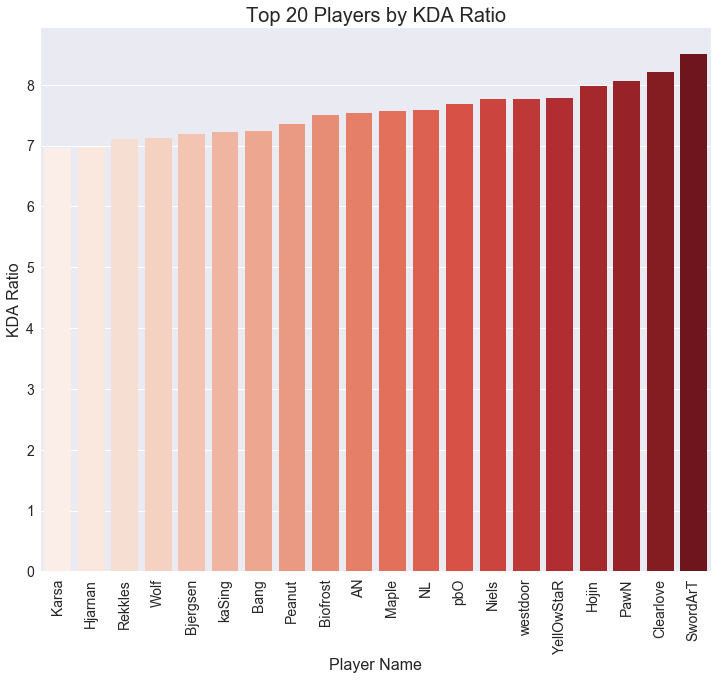

In [20]:
# create plot - most banned champion 2017
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_y', palette='Reds', data=pk_plot);
plt.title("Top 20 Players by KDA Ratio",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

The players on this list tend to be the more conservative types (Rekkles) or supports, which are not generally the first target in a match (SwordArT, YellOwStaR). Bjergson is notable for being the most popular Western LoL player. He is a member of TSM. The support for TSM for the last year or so has been Biofrost, who also shows up here. Biofrost is interesting as he plays fairly aggressively, but for a team that is generally well-coordinated and individually strong and can cover his weaknesses. 

## Positional KDA Ratios
Each LoL game is 5 vs. 5, with each player falling into 1 of 5 roles. Let's take a look at KDA ratios across the positions.

In [21]:
# get series of each player's position
top = gen_df.loc[:,'top_player']
jgl = gen_df.loc[:,'jungle_player']
mid = gen_df.loc[:,'mid_player']
adc = gen_df.loc[:,'adc_player']
sup = gen_df.loc[:,'support_player']

In [22]:
# create dataframes for each position
top_df = pk_df.loc[pk_df.player.isin(top),:]
jgl_df = pk_df.loc[pk_df.player.isin(jgl),:]
mid_df = pk_df.loc[pk_df.player.isin(mid),:]
adc_df = pk_df.loc[pk_df.player.isin(adc),:]
sup_df = pk_df.loc[pk_df.player.isin(sup),:]

In [23]:
top_plot = kda_ratio(top_df)
jgl_plot = kda_ratio(jgl_df)
mid_plot = kda_ratio(mid_df)
adc_plot = kda_ratio(adc_df)
sup_plot = kda_ratio(sup_df)

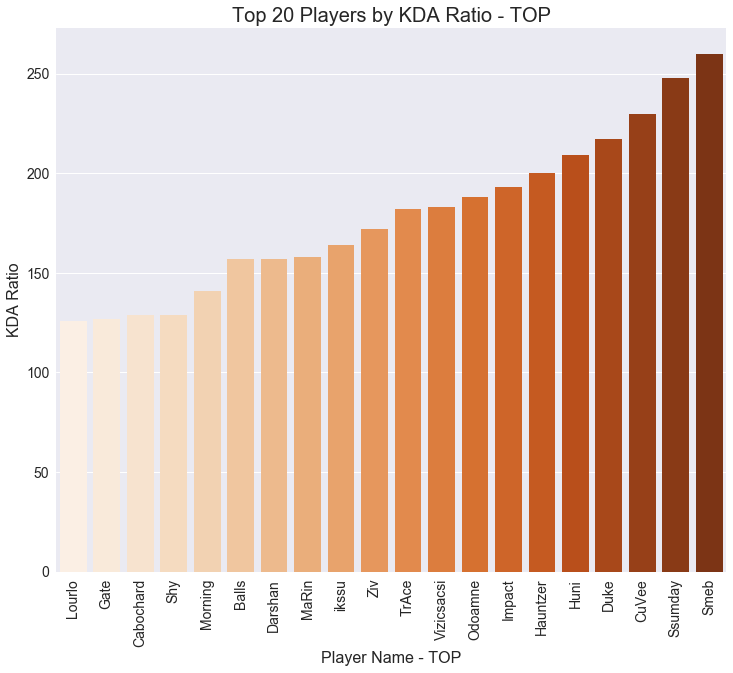

In [24]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=top_plot);
plt.title("Top 20 Players by KDA Ratio - TOP",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - TOP", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

‘Top’ refers to the top lane on the game map. These players generally play sturdier, ‘tank’ class Champions. The inclusion of ZionSpartan and Lourlo is somewhat surprising as they are decent, but not particularly noteworthy top-laners. Hauntzer is another member of TSM. Smeb is probably the best current top-laner, and his position on the chart reflects that. 

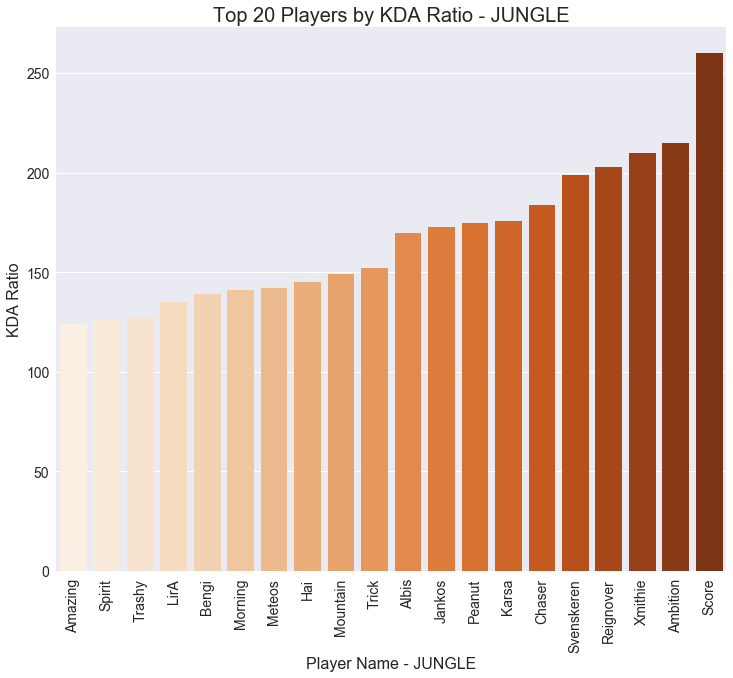

In [25]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=jgl_plot);
plt.title("Top 20 Players by KDA Ratio - JUNGLE",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - JUNGLE", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

‘Jungle’ players roam the jungle areas on the map, and it’s their job to provide pressure to the other lanes, and help their team gain an advantage. Many of the players on this list are retired or otherwise out of the game. Meteos is one of the most notable examples. When he started as a member of C9, his slow-paced playstyle had a dramatic impact on how the game was played world-wide. Peanut is one of the better current junglers and is currently a member of SKT.

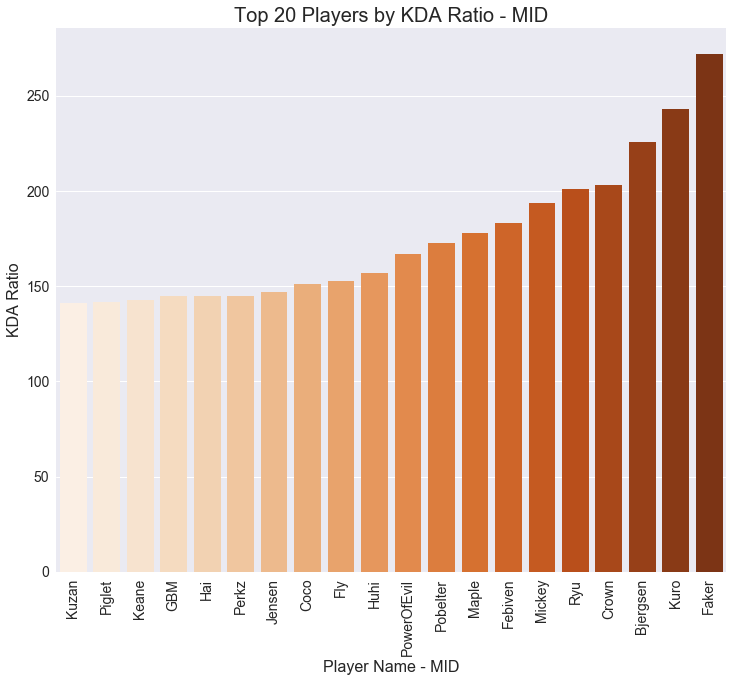

In [26]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=mid_plot);
plt.title("Top 20 Players by KDA Ratio - MID",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - MID", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

'Mid' refers to the middle lane. These players chose mage-type Champions generally that excel at dishing out damage. A player that I’ve not yet mentioned shows up here – Faker. A member of SKT, Faker is known as the greatest LoL player ever. While his KDA ratio is quite good, his mastery of strategy and knack for clutch plays that can turn games around are his hallmarks. 

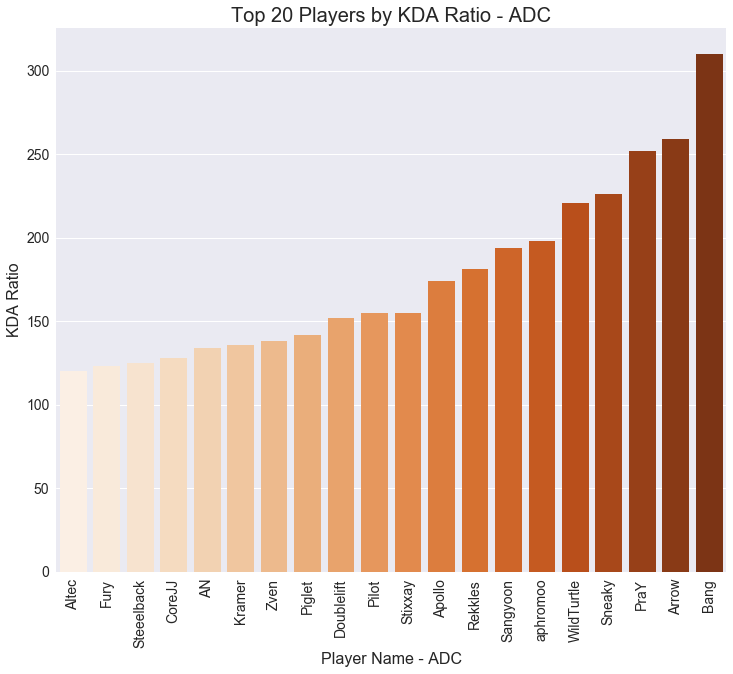

In [27]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=adc_plot);
plt.title("Top 20 Players by KDA Ratio - ADC",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - ADC", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

'ADC' (Attack Damage Carry) players can be found in the bottom lane. These players tend to pick ranged damage dealers. Doublelift is one of the more notable players here as he has been around since the beginning of professional LoL. Currently, he is a member of TSM and remains a very effective player. 

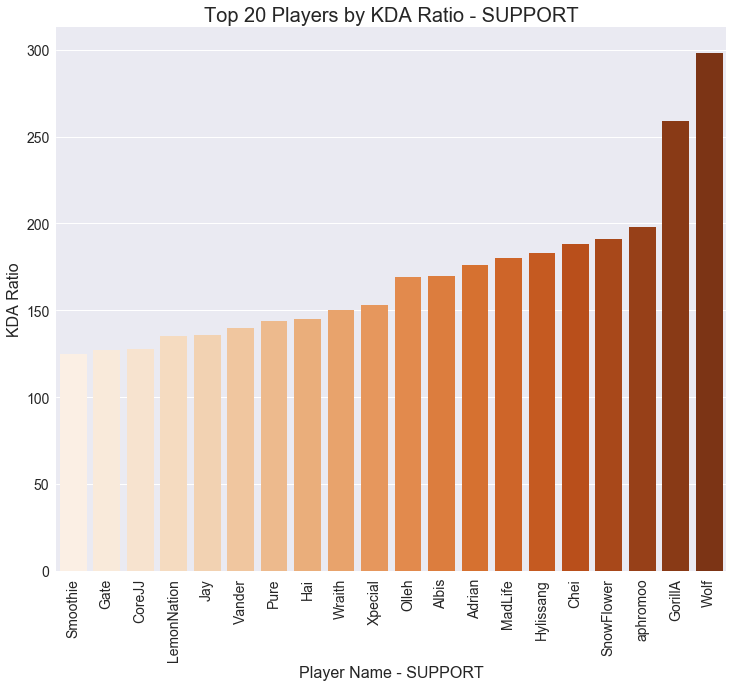

In [28]:
# create plot - top
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player', y='kda_ratio_x', palette='Oranges', data=sup_plot);
plt.title("Top 20 Players by KDA Ratio - SUPPORT",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name - SUPPORT", fontsize=16)
plt.ylabel("KDA Ratio", fontsize=16);

Support players begin the game in the bottom lane as well, supporting the ADC. These players are not damage dealers, instead they focus on crowd control (disabling enemy players), healing, shielding, and on placing wards around the map which grant vision to their team. Biofrost being so high up on the list is quite surprising – for a new player on an established team he has performed extremely well.

# Why is LoL a difficult game to analyze?

Now that we have looked at the data from a high-level perspective, and gotten a sense for what factors go into winning a League of Legends game, lets see some of the issues with trying to analyze LoL data.

Most importantly, win conditions are highly variable. By that I mean a team could win with 5 kills in 20 minutes or 30 kills in 80 minutes. A team could even win while being behind in gold, kills, objectives, and any other possible measurement. Any win is equally valid. Quantifiable metrics also vary across teams which have different playstyles. 

The following visualizations will demonstrate some of these issues.

## Length of a Game and Total Gold
One of the most obvious metrics to analyze is total gold. Gold is a measurement of how effective a team has been up to that point in the game. The problem is that totals will be inherently lower the shorter the game length.

In [29]:
gt_df2 = gt_df.loc[gt_df['type'] == 'total_gold',:]

# find the max value in each row
total_g = gt_df2.max(numeric_only= True, axis=1)
total_g = total_g.reset_index()

# merge total gold, result, game_length
gdf = gt_df2[['result', 'game_length']]
gt_df2.reset_index(inplace=True, drop=True)
gdf = pd.merge(gdf, total_g, left_index=True, right_index=True)
gdf.drop('index', inplace=True, axis=1)
gdf.rename(columns={0:'total_gold'}, inplace=True)
gdf['result']=gdf['result'].replace(0, 'Loss')
gdf['result']=gdf['result'].replace(1, 'Win')

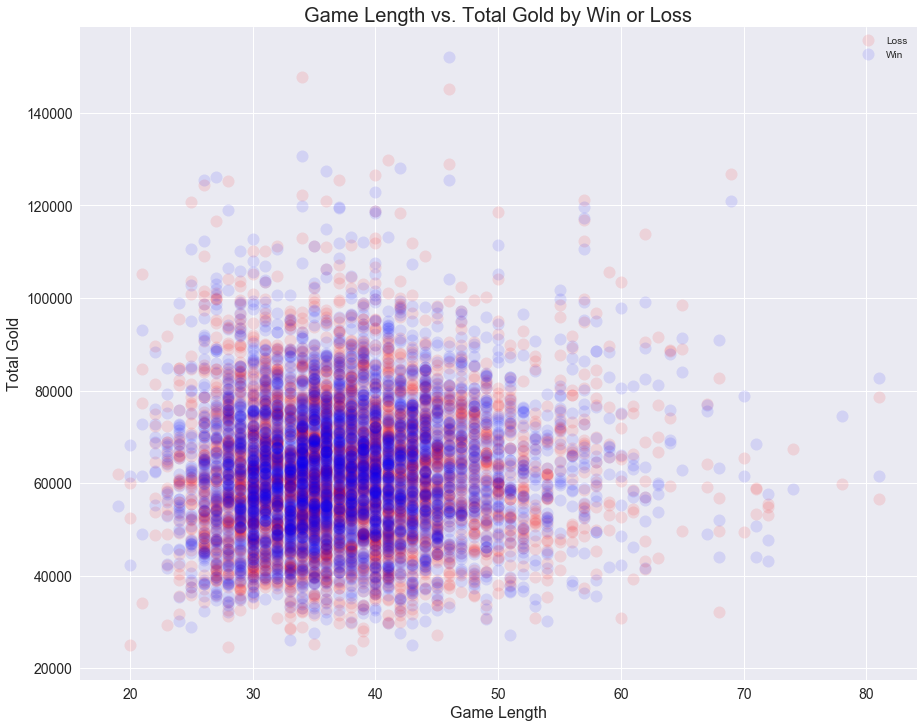

In [30]:
# create scatterplot
fig, ax = plt.subplots(figsize=(15,12))
groups = gdf.groupby('result')
i=0
for name, group in groups:
    if i == 0:
        ax.plot(group.game_length, group.total_gold, marker='o',color='r', 
                linestyle='', ms=12, label=name, alpha=0.1)
        i+=1
    else:
        ax.plot(group.game_length, group.total_gold, marker='o',color='b', 
                linestyle='', ms=12, label=name, alpha=0.1)
ax.legend()

plt.title("Game Length vs. Total Gold by Win or Loss",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Game Length", fontsize=16)
plt.ylabel("Total Gold", fontsize=16);

The scatterplot above is separated by wins and losses. As noted, it is possible to win playing LoL with very different styles. Additionally, the overall game 'meta' (or playstyle) changes over time as new strategies are discovered.

## Total Kills and Wins/Losses

Much like total gold, kills vary wildly. Some games are very passive, while others are a comparitive blood-bath. 

In [31]:
# create kills/result df
tk = tk_df[['match_id', 'team_name','kills']]
gen = gen_df[['match_id','team_name', 'result']]
merge_tk = pd.merge(tk, gen, left_on=['match_id', 'team_name'], right_on=['match_id', 'team_name'])
merge_tk.drop(['match_id', 'team_name'], inplace=True, axis=1)

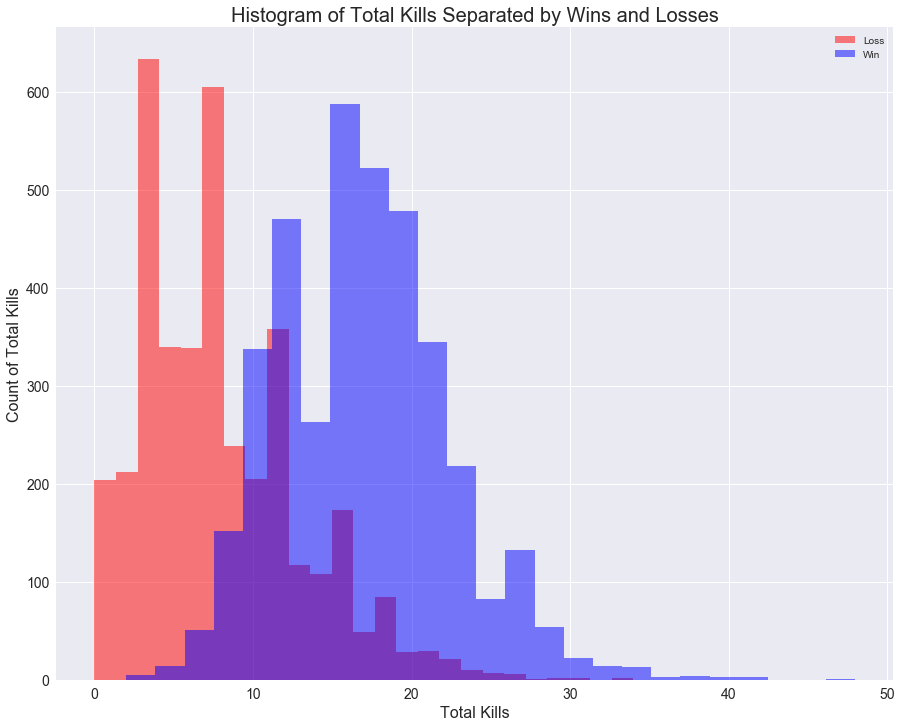

In [32]:
fig, ax = plt.subplots(figsize=(15,12))
plt.hist(merge_tk[merge_tk['result']==0]['kills'].reset_index(drop=True),alpha=0.5,bins=25,label='Loss',color='r')
plt.hist(merge_tk[merge_tk['result']==1]['kills'].reset_index(drop=True),alpha=0.5,bins=25,label='Win',color='b')
plt.legend()
plt.title("Histogram of Total Kills Separated by Wins and Losses",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Total Kills", fontsize=16)
plt.ylabel("Count of Total Kills", fontsize=16);

The histogram above shows similar histograms for wins and losses, just with wins shifted downward which is to be expected. The winning team will likely have **MORE** wins than the losing team, but exactly what those numbers are is tough to predict.

## Champions
Another wrinkle is that each team chooses 5 of ~140 Champions to play as each game. Can you predict wins based on the Champion picked? 

In [33]:
# pull data from general df
tdf = gen_df[['result','top_champ']]
jdf = gen_df[['result','jungle_champ']]
mdf = gen_df[['result','mid_champ']]
adf = gen_df[['result','adc_champ']]
sdf = gen_df[['result','support_champ']]

# rename columns to match
all_dfs = [tdf, jdf, mdf, adf, sdf]
for df in all_dfs:
    df.columns = ['result', 'champion']
    
# concat together
mcdf = pd.concat(all_dfs).reset_index(drop=True)
mcdf['result1'] = mcdf['result']

# get pivot_table counts
mcpt = mcdf.pivot_table(index=['champion','result'], values='result1', aggfunc='count')
mcpt.reset_index(inplace=True)
mcpt = mcpt.loc[mcpt['result1'] >= 75,:]

# reorganize columns
mcpt_wins = mcpt.loc[mcpt['result']==1,:].set_index('champion')
mcpt_losses = mcpt.loc[mcpt['result']==0,:].set_index('champion')

# calculate win_pct
mcptc = mcpt_wins.join(mcpt_losses, lsuffix="_x", rsuffix='_y').dropna()
mcptc = mcptc.reset_index()
mcptc['total_games'] = mcptc['result1_x'] + mcptc['result1_y']
mcptc['win_pct'] = mcptc['result1_x'] / mcptc['total_games']
mcptc = mcptc[['champion','win_pct']]

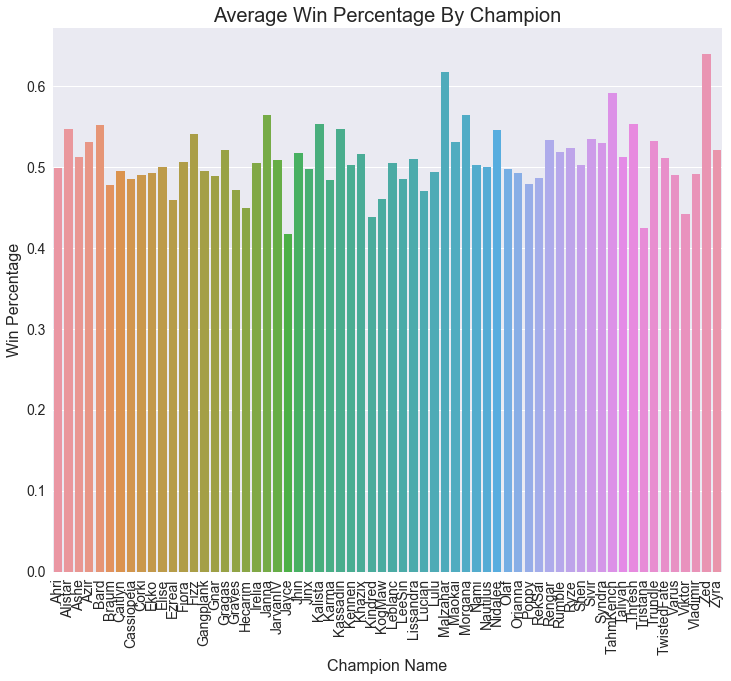

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

sns.barplot(x='champion', y='win_pct', data=mcptc, ci=None);
plt.title("Average Win Percentage By Champion",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Champion Name", fontsize=16)
plt.ylabel("Win Percentage", fontsize=16);

The bar plot above shows average win percentages across Champions. Let's see the aggregate mean.

In [35]:
print('The average win percentage across all champions is %.2f%%' % (mcptc['win_pct'].mean() * 100))

The average win percentage across all champions is 50.88%


One important factor to Champion win percentages is that Riot Games is always adjusting game balance. So if one particular Champion is strong during a period of time, it is unlikely that Riot will allow that to continue for very long. Zed and Malzahar from the bar plot are examples of this. For a few months each was considered 'overpowered', or strong for their roles compared to other similar Champions. Riot made adjustments to bring the power level down, and consequently they are very rarely picked anymore. 

Making predictions on Champion's would have to be very carefully consider the shifting nature of the game.

# Gold Values across Games
## Total Gold

As mentioned, gold totals for each team give an idea of relative power levels for each team. I will be looking at both total gold values for each team at 1 minute intervals, as well as the gold differential between each team. 

For this analysis, I will use the 2016 World Championship Finals between Samsung Galaxy and SKT.

In [36]:
# select only the games from 2016 World Championships
champ_df = gt_df.loc[(gt_df['league'] == 'Season_World_Championship') &
                      (gt_df['year'] == 2016) & (gt_df['type'] == 'total_gold'),:]

# the finals were played by SKT and SSG
finals_df = champ_df.loc[(champ_df['team_name'] == 'SSG') | (champ_df['team_name'] == 'SKT'),:]

In [37]:
# select only the 5 games from the finals
fin_df = finals_df.loc[(finals_df['match_id'] == '473fc1deff74591b') |
                      (finals_df['match_id'] == '2a1d6285ce9dd71f') |
                      (finals_df['match_id'] == '6ca759012b24b8b1') |
                      (finals_df['match_id'] == 'ac33fc72f78724a8') |
                      (finals_df['match_id'] == 'e5af5592e36bdb01'),:]

In [38]:
game1 = fin_df.loc[(fin_df['match_id'] == 'e5af5592e36bdb01'),:]
game1 = transform_df(game1)

# rename columns 
game1 = game1.rename(columns = {6814:'SSG',6815:'SKT'})

# only select rows where the game is being played
# after the game ends the values are 0
game1 = game1.loc[(game1['SKT'] != 0),:]

#format time
time1 = pd.date_range("0:00", "0:54", freq="1min", format='%H:%M')
game1 = format_time(game1, time1)

In [39]:
game2 = fin_df.loc[(fin_df['match_id'] == '473fc1deff74591b'),:]
game2 = transform_df(game2)
game2 = game2.rename(columns = {2077:'SKT',2076:'SSG'})
game2 = game2.loc[(game2['SKT'] != 0),:]
time2 = pd.date_range("0:00", "0:31", freq="1min", format='%H:%M')
game2 = format_time(game2, time2)

In [40]:
game3 = fin_df.loc[(fin_df['match_id'] == '6ca759012b24b8b1'),:]
game3 = transform_df(game3)
game3 = game3.rename(columns = {3205:'SKT',3204:'SSG'})
game3 = game3.loc[(game3['SKT'] != 0),:]
time3 = pd.date_range("0:00", "1:11", freq="1min", format='%H:%M')
game3 = format_time(game3, time3)

In [41]:
game4 = fin_df.loc[(fin_df['match_id'] == '2a1d6285ce9dd71f'),:]
game4 = transform_df(game4)
game4 = game4.rename(columns = {1222:'SKT',1223:'SSG'})
game4 = game4.loc[(game4['SKT'] != 0),:]
time4 = pd.date_range("0:00", "0:46", freq="1min", format='%H:%M')
game4 = format_time(game4, time4)

In [42]:
game5 = fin_df.loc[(fin_df['match_id'] == 'ac33fc72f78724a8'),:]
game5 = transform_df(game5)
game5 = game5.rename(columns = {5090:'SKT',5091:'SSG'})
game5 = game5.loc[(game5['SKT'] != 0),:]
time5 = pd.date_range("0:00", "0:49", freq="1min", format='%H:%M')
game5 = format_time(game5, time5)

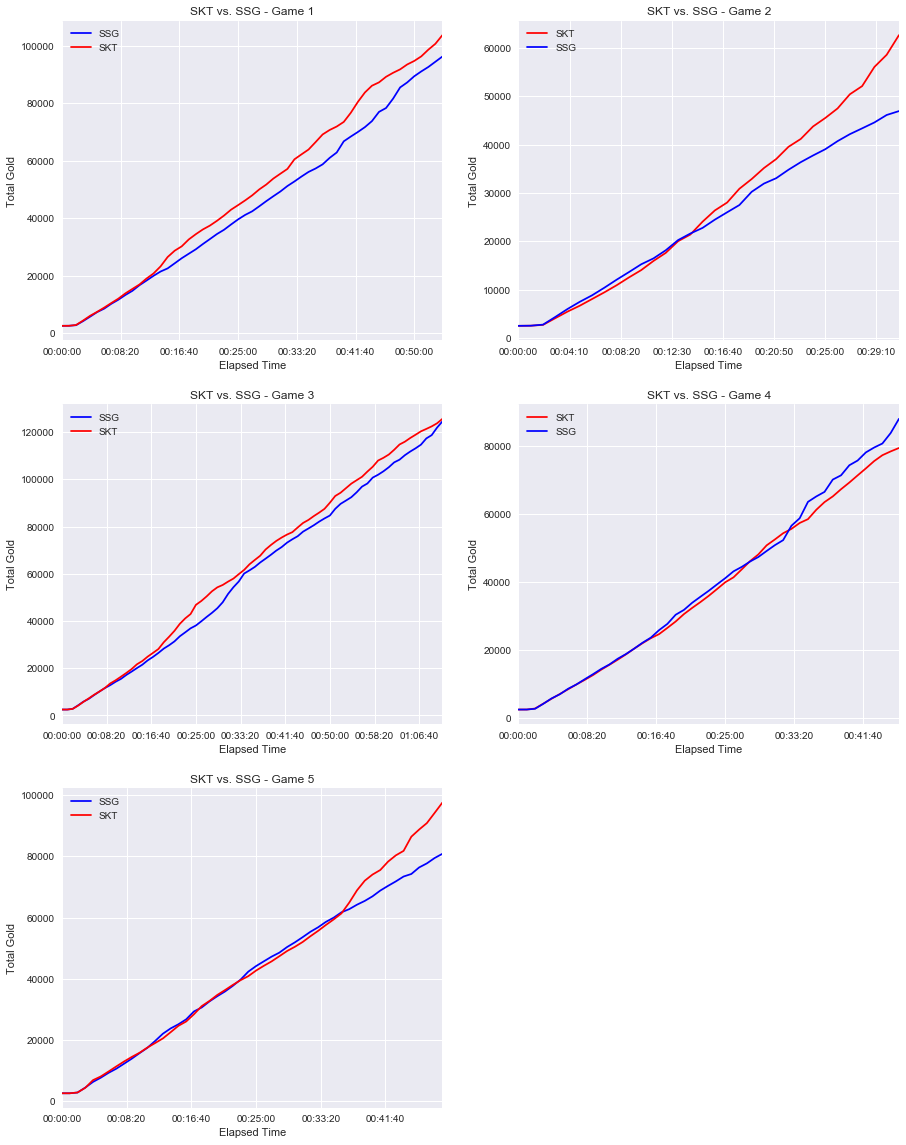

In [43]:
# create subplot
fig, axes = plt.subplots(3,2)

# create subplot plots
styles1 = ['b','r']
line1 = game1.plot(style=styles1,figsize=(15,20),ax=axes[0,0])
line1.tick_params(labelsize=10)
line1.set_xlabel('Elapsed Time')
line1.set_ylabel('Total Gold')
line1.set_title("SKT vs. SSG - Game 1")
styles2 = ['r','b']
line2 = game2.plot(style=styles2,figsize=(15,20),ax=axes[0,1])
line2.tick_params(labelsize=10)
line2.set_xlabel('Elapsed Time')
line2.set_ylabel('Total Gold')
line2.set_title("SKT vs. SSG - Game 2")
styles3 = ['b','r']
line3 = game3.plot(style=styles3,figsize=(15,20),ax=axes[1,0])
line3.tick_params(labelsize=10)
line3.set_xlabel('Elapsed Time')
line3.set_ylabel('Total Gold')
line3.set_title("SKT vs. SSG - Game 3")
styles4 = ['r','b']
line4 = game4.plot(style=styles4,figsize=(15,20),ax=axes[1,1])
line4.tick_params(labelsize=10)
line4.set_xlabel('Elapsed Time')
line4.set_ylabel('Total Gold')
line4.set_title("SKT vs. SSG - Game 4")
styles5 = ['b','r']
line5 = game5.plot(style=styles5,figsize=(15,20),ax=axes[2,0])
line5.tick_params(labelsize=10)
line5.set_xlabel('Elapsed Time')
line5.set_ylabel('Total Gold')
line5.set_title("SKT vs. SSG - Game 5")
fig.delaxes(axes[2,1]);

Total gold is gained in several fashions - farming, taking objectives/structures, and killing opposing players. The line plots above tell the story of the series. It was a fairly close series, with a lot of back and forth between the teams. 

## Gold Differential
Gold differential is another way to look at gold values in a game. As the gold differential grows it becomes more and more difficult for the trailing team to make a comeback. It is not impossible however, and this happens routinely as the total gold charts demonstrate.

In [44]:
# select only the games from 2016 World Championships
champ_df = gm_df.loc[(gm_df['league'] == 'Season_World_Championship') &
                      (gm_df['year'] == 2016) & (gm_df['type'] == 'total_gold'),:]

# the finals were played by SKT and SSG
finals_df = champ_df.loc[(champ_df['team_name'] == 'SSG') | (champ_df['team_name'] == 'SKT'),:]

In [45]:
# select only the 5 games from the finals
fin_df = finals_df.loc[(finals_df['match_id'] == '473fc1deff74591b') |
                      (finals_df['match_id'] == '2a1d6285ce9dd71f') |
                      (finals_df['match_id'] == '6ca759012b24b8b1') |
                      (finals_df['match_id'] == 'ac33fc72f78724a8') |
                      (finals_df['match_id'] == 'e5af5592e36bdb01'),:]

In [46]:
# select only rows for this game
game1_d = fin_df.loc[(fin_df['match_id'] == 'e5af5592e36bdb01'),:]
game1_d = transform_df(game1_d)

# rename columns 
game1_d = game1_d.rename(columns = {6814:'SSG',6815:'SKT'})

# add seconds, and reshape df
game1_d = gold_diff_df(game1_d)
game1_d['time'] = game1_d.apply(lambda row: seconds(row['index']+1),axis=1)
game1_d['seconds'] = game1_d['time']

# create kills df
kills_skt = kills_df.loc[(kills_df['match_id'] =='e5af5592e36bdb01') &
                      (kills_df['team_name'] == 'SKT'),:]
kills_ssg = kills_df.loc[(kills_df['match_id'] =='e5af5592e36bdb01') &
                      (kills_df['team_name'] == 'SSG'),:]

# merge with game df to get y values for plotting
mkills_skt = pd.merge(kills_skt, game1_d, how='inner', on='time')
mkills_ssg = pd.merge(kills_ssg, game1_d, how='inner', on='time')

# graph SSG kills at y=0
mkills_ssg['SSG'] = 0

# get counts of kills at each time point to adjust size
mkills_skt = size_points(mkills_skt)
mkills_ssg = size_points(mkills_ssg)

# reduce df for line plot
fg1 = game1_d[['time','SKT']]
fg1 = fg1.set_index('time')

#creat stem plot df
skt1 = pd.read_csv('skt1.1.csv',index_col=0)
ssg1 = pd.read_csv('ssg1.1.csv',index_col=0)
skt1 = stem_data(skt1, fg1)
ssg1 = stem_data(ssg1, fg1)

# create the data for the other games
game2_d = fin_df.loc[(fin_df['match_id'] == '473fc1deff74591b'),:]
game2_d = transform_df(game2_d)
game2_d = game2_d.rename(columns = {2077:'SSG',2076:'SKT'})
game2_d = gold_diff_df(game2_d)
game2_d['time'] = game2_d.apply(lambda row: seconds(row['index']+1),axis=1)
game2_d['seconds'] = game2_d['time']
kills_skt2 = kills_df.loc[(kills_df['match_id'] =='473fc1deff74591b') &
                      (kills_df['team_name'] == 'SKT'),:]
kills_ssg2 = kills_df.loc[(kills_df['match_id'] =='473fc1deff74591b') &
                      (kills_df['team_name'] == 'SSG'),:]
mkills_skt2 = pd.merge(kills_skt2, game2_d, how='inner', on='time')
mkills_ssg2 = pd.merge(kills_ssg2, game2_d, how='inner', on='time')
mkills_ssg2['SSG'] = 0
mkills_skt2 = size_points(mkills_skt2)
mkills_ssg2 = size_points(mkills_ssg2)
fg2 = game2_d[['time','SKT']]
fg2 = fg2.set_index('time')
skt2 = pd.read_csv('skt2.1.csv',index_col=0)
ssg2 = pd.read_csv('ssg2.1.csv',index_col=0)
skt2 = stem_data(skt2, fg2)
ssg2 = stem_data(ssg2, fg2)

game3_d = fin_df.loc[(fin_df['match_id'] == '6ca759012b24b8b1'),:]
game3_d = transform_df(game3_d)
game3_d = game3_d.rename(columns = {3204:'SSG',3205:'SKT'})
game3_d = gold_diff_df(game3_d)
game3_d['time'] = game3_d.apply(lambda row: seconds(row['index']+1),axis=1)
game3_d['seconds'] = game3_d['time']
kills_skt3 = kills_df.loc[(kills_df['match_id'] =='6ca759012b24b8b1') &
                      (kills_df['team_name'] == 'SKT'),:]
kills_ssg3 = kills_df.loc[(kills_df['match_id'] =='6ca759012b24b8b1') &
                      (kills_df['team_name'] == 'SSG'),:]
mkills_skt3 = pd.merge(kills_skt3, game3_d, how='inner', on='time')
mkills_ssg3 = pd.merge(kills_ssg3, game3_d, how='inner', on='time')
mkills_ssg3['SSG'] = 0
mkills_skt3 = size_points(mkills_skt3)
mkills_ssg3 = size_points(mkills_ssg3)
fg3 = game3_d[['time','SKT']]
fg3 = fg3.set_index('time')
skt3 = pd.read_csv('skt3.1.csv',index_col=0)
ssg3 = pd.read_csv('ssg3.1.csv',index_col=0)
skt3 = stem_data(skt3, fg3)
ssg3 = stem_data(ssg3, fg3)

game4_d = fin_df.loc[(fin_df['match_id'] == '2a1d6285ce9dd71f'),:]
game4_d = transform_df(game4_d)
game4_d = game4_d.rename(columns = {1223:'SSG',1222:'SKT'})
game4_d = gold_diff_df(game4_d)
game4_d['time'] = game4_d.apply(lambda row: seconds(row['index']+1),axis=1)
game4_d['seconds'] = game4_d['time']
kills_skt4 = kills_df.loc[(kills_df['match_id'] =='2a1d6285ce9dd71f') &
                      (kills_df['team_name'] == 'SKT'),:]
kills_ssg4 = kills_df.loc[(kills_df['match_id'] =='2a1d6285ce9dd71f') &
                      (kills_df['team_name'] == 'SSG'),:]
mkills_skt4 = pd.merge(kills_skt4, game4_d, how='inner', on='time')
mkills_ssg4 = pd.merge(kills_ssg4, game4_d, how='inner', on='time')
mkills_ssg4['SSG'] = 0
mkills_skt4 = size_points(mkills_skt4)
mkills_ssg4 = size_points(mkills_ssg4)
fg4 = game4_d[['time','SKT']]
fg4 = fg4.set_index('time')
skt4 = pd.read_csv('skt4.1.csv',index_col=0)
ssg4 = pd.read_csv('ssg4.1.csv',index_col=0)
skt4 = stem_data(skt4, fg4)
ssg4 = stem_data(ssg4, fg4)

game5_d = fin_df.loc[(fin_df['match_id'] == 'ac33fc72f78724a8'),:]
game5_d = transform_df(game5_d)
game5_d = game5_d.rename(columns = {5090:'SSG',5091:'SKT'})
game5_d = gold_diff_df(game5_d)
game5_d['time'] = game5_d.apply(lambda row: seconds(row['index']+1),axis=1)
game5_d['seconds'] = game5_d['time']
kills_skt5 = kills_df.loc[(kills_df['match_id'] =='ac33fc72f78724a8') &
                      (kills_df['team_name'] == 'SKT'),:]
kills_ssg5 = kills_df.loc[(kills_df['match_id'] =='ac33fc72f78724a8') &
                      (kills_df['team_name'] == 'SSG'),:]
mkills_skt5 = pd.merge(kills_skt5, game5_d, how='inner', on='time')
mkills_ssg5 = pd.merge(kills_ssg5, game5_d, how='inner', on='time')
mkills_ssg5['SSG'] = 0
mkills_skt5 = size_points(mkills_skt5)
mkills_ssg5 = size_points(mkills_ssg5)
fg5 = game5_d[['time','SKT']]
fg5 = fg5.set_index('time')
skt5 = pd.read_csv('skt5.1.csv',index_col=0)
ssg5 = pd.read_csv('ssg5.1.csv',index_col=0)
skt5 = stem_data(skt5, fg5)
ssg5 = stem_data(ssg5, fg5)

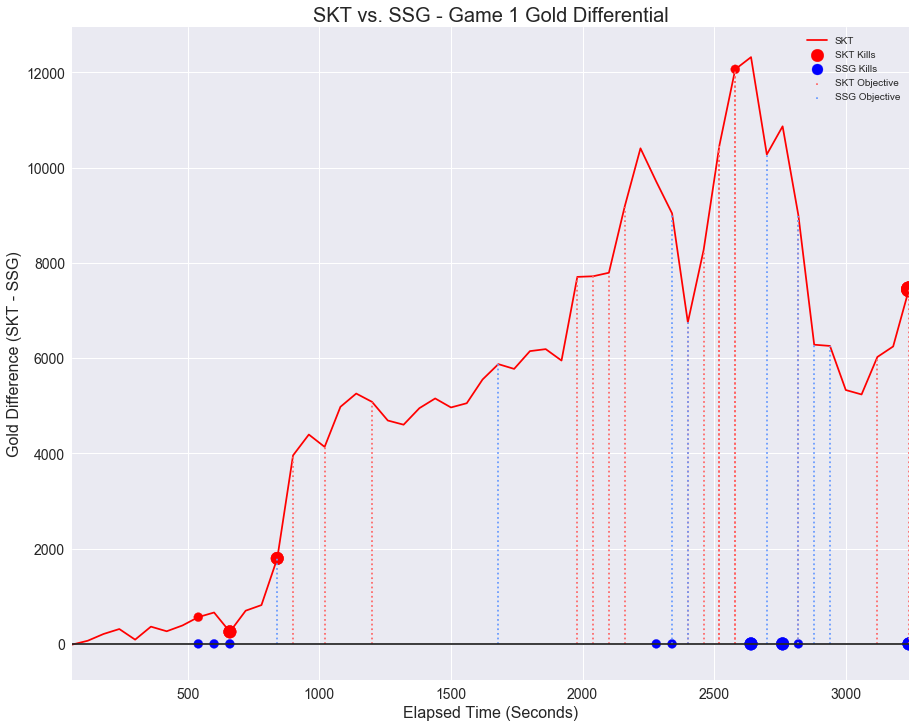

In [47]:
# create plot
line = fg1.plot(figsize=(15,12),color='r',)
plt.scatter(mkills_skt['time'], mkills_skt['SKT'],color='r',s=mkills_skt['count'],label='SKT Kills')
plt.scatter(mkills_ssg['time'], mkills_ssg['SSG'],color='b',s=mkills_ssg['count'],label='SSG Kills')
markerlines,stemlines,baseline = plt.stem(skt1['time'], skt1['SKT'],basefmt=' ',
                                          label='SKT Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines,'color','#ff6666')
plt.setp(markerlines,'color','#ff6666')
markerlines1,stemlines1,baseline1 = plt.stem(ssg1['time'], ssg1['SKT'],basefmt=' ',
                                             label='SSG Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines1,'color','#6699ff')
plt.setp(markerlines1,'color','#6699ff')
plt.axhline(y=0,color='#262626')

# format plot
plt.legend()
plt.title("SKT vs. SSG - Game 1 Gold Differential",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Elapsed Time (Seconds)", fontsize=16)
plt.ylabel("Gold Difference (SKT - SSG)", fontsize=16);

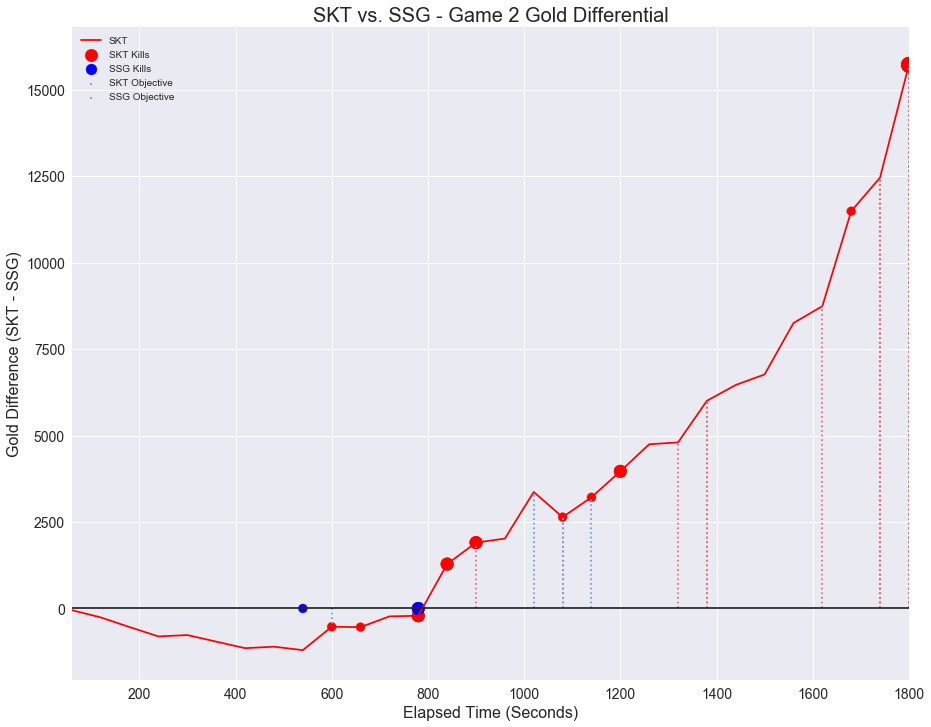

In [48]:
# create plot
line = fg2.plot(figsize=(15,12),color='r')
plt.scatter(mkills_skt2['time'], mkills_skt2['SKT'],color='r',s=mkills_skt2['count'],label='SKT Kills')
plt.scatter(mkills_ssg2['time'], mkills_ssg2['SSG'],color='b',s=mkills_ssg2['count'],label='SSG Kills')
markerlines,stemlines,baseline = plt.stem(skt2['time'], skt2['SKT'],basefmt=' ',
                                          label='SKT Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines,'color','#ff6666')
plt.setp(markerlines,'color','#ff6666')
markerlines1,stemlines1,baseline1 = plt.stem(ssg2['time'], ssg2['SKT'],basefmt=' ',
                                             label='SSG Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines1,'color','#6699ff')
plt.setp(markerlines1,'color','#6699ff')
plt.axhline(y=0,color='#262626')

# format plot
plt.legend()
plt.title("SKT vs. SSG - Game 2 Gold Differential",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Elapsed Time (Seconds)", fontsize=16)
plt.ylabel("Gold Difference (SKT - SSG)", fontsize=16);

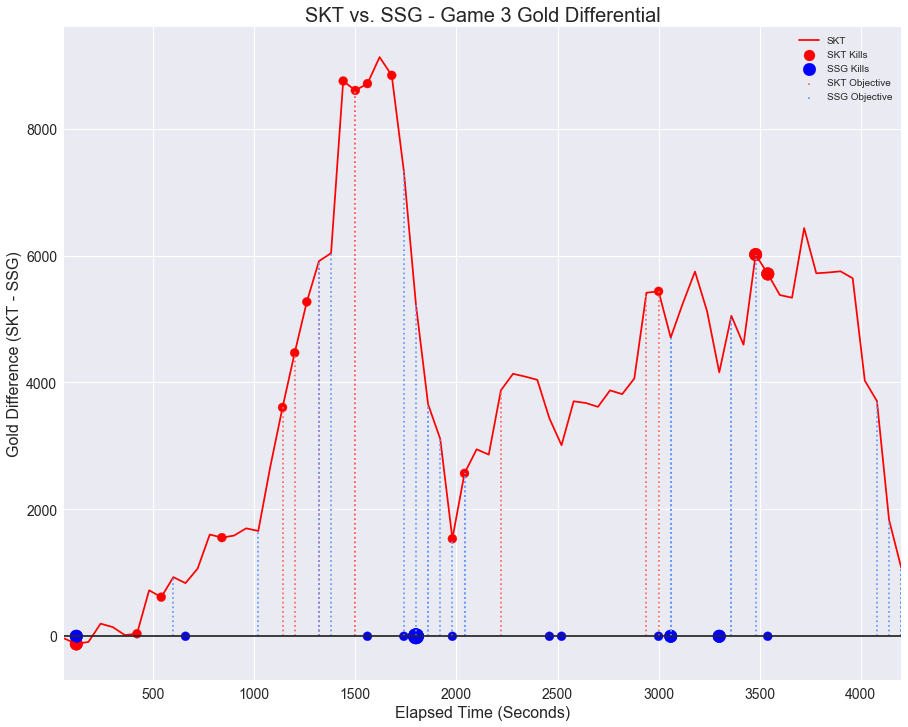

In [49]:
# create plot
line = fg3.plot(figsize=(15,12),color='r')
plt.scatter(mkills_skt3['time'], mkills_skt3['SKT'],color='r',s=mkills_skt3['count'],label='SKT Kills')
plt.scatter(mkills_ssg3['time'], mkills_ssg3['SSG'],color='b',s=mkills_ssg3['count'],label='SSG Kills')
markerlines,stemlines,baseline = plt.stem(skt3['time'], skt3['SKT'],basefmt=' ',
                                          label='SKT Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines,'color','#ff6666')
plt.setp(markerlines,'color','#ff6666')
markerlines1,stemlines1,baseline1 = plt.stem(ssg3['time'], ssg3['SKT'],basefmt=' ',
                                             label='SSG Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines1,'color','#6699ff')
plt.setp(markerlines1,'color','#6699ff')
plt.axhline(y=0,color='#262626')

# format plot
plt.legend()
plt.title("SKT vs. SSG - Game 3 Gold Differential",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Elapsed Time (Seconds)", fontsize=16)
plt.ylabel("Gold Difference (SKT - SSG)", fontsize=16);

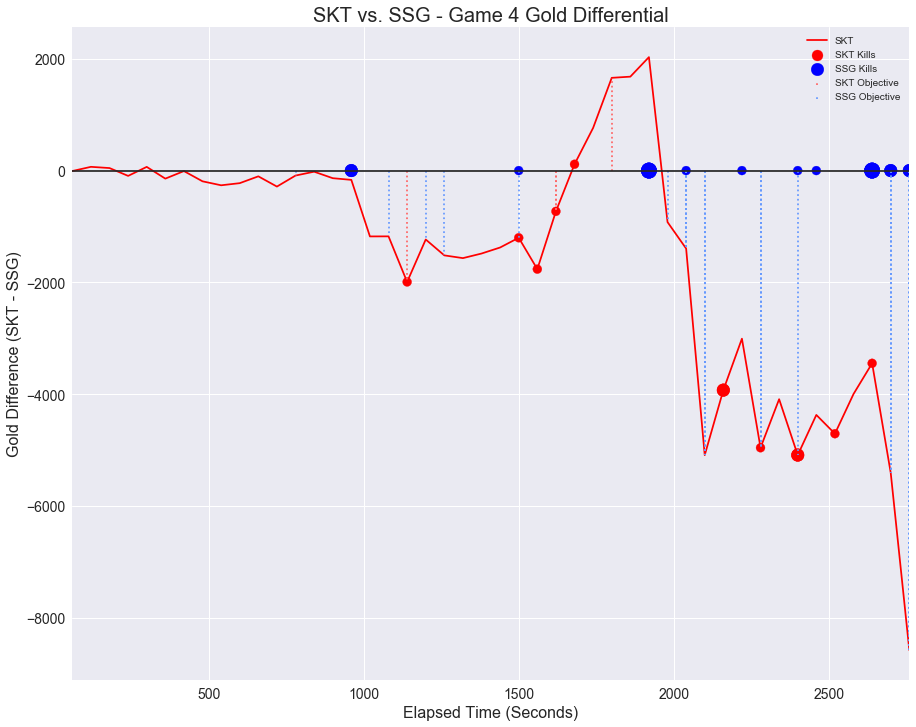

In [50]:
# create plot
line = fg4.plot(figsize=(15,12),color='r')
plt.scatter(mkills_skt4['time'], mkills_skt4['SKT'],color='r',s=mkills_skt4['count'],label='SKT Kills')
plt.scatter(mkills_ssg4['time'], mkills_ssg4['SSG'],color='b',s=mkills_ssg4['count'],label='SSG Kills')
markerlines,stemlines,baseline = plt.stem(skt4['time'], skt4['SKT'],basefmt=' ',
                                          label='SKT Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines,'color','#ff6666')
plt.setp(markerlines,'color','#ff6666')
markerlines1,stemlines1,baseline1 = plt.stem(ssg4['time'], ssg4['SKT'],basefmt=' ',
                                             label='SSG Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines1,'color','#6699ff')
plt.setp(markerlines1,'color','#6699ff')
plt.axhline(y=0,color='#262626')
# format plot
plt.legend()
plt.title("SKT vs. SSG - Game 4 Gold Differential",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Elapsed Time (Seconds)", fontsize=16)
plt.ylabel("Gold Difference (SKT - SSG)", fontsize=16);

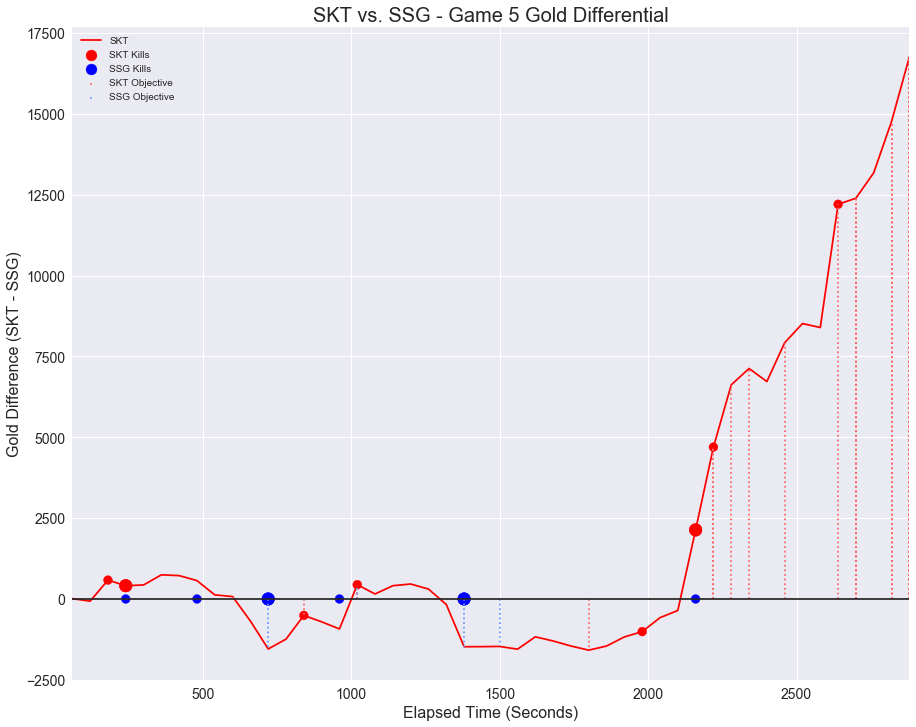

In [51]:
# create plot
line = fg5.plot(figsize=(15,12),color='r')
plt.scatter(mkills_skt5['time'], mkills_skt5['SKT'],color='r',s=mkills_skt5['count'],label='SKT Kills')
plt.scatter(mkills_ssg5['time'], mkills_ssg5['SSG'],color='b',s=mkills_ssg5['count'],label='SSG Kills')
markerlines,stemlines,baseline = plt.stem(skt5['time'], skt5['SKT'],basefmt=' ',label='SKT Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines,'color','#ff6666')
plt.setp(markerlines,'color','#ff6666')
markerlines1,stemlines1,baseline1 = plt.stem(ssg5['time'], ssg5['SKT'],basefmt=' ',label='SSG Objective',linefmt=':',markerfmt=' ')
plt.setp(stemlines1,'color','#6699ff')
plt.setp(markerlines1,'color','#6699ff')
plt.axhline(y=0,color='#262626')
# format plot
plt.legend()
plt.title("SKT vs. SSG - Game 5 Gold Differential",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Elapsed Time (Seconds)", fontsize=16)
plt.ylabel("Gold Difference (SKT - SSG)", fontsize=16);

These plots show the different types of games that can be played in LoL. There are 1-sided matches where 1 team gains the lead early and never lets it go (games 1 and 2), epic come from behind wins (game 3), and back-and-forth matches (games 4 and 5) where the winner is not decided until the end. 

The differences in number of kills and objectives taken also is nicely illustrated here. Some games are fast-paced with lots of fights/deaths, and some are the opposite. This shift in mentality is due to many factors (these games being the World Championships probably played into it), but it is possible for the same team to win a series playing very distinct styles of LoL in each game.

## Early Game Farming

There is one other aspect to LoL that has not been covered yet - farming. This is the practice of killing neutral monsters that grant additional gold, and is very important. 

To measure which players are the most effective farmers throughout the data I will compare gold earned to possible gold  for the first 20 minutes of a game. This number will not be 100% accurate for a few reasons. Gold values have fluctuated over time as Riot makes changes to the game and the exact gold values at given time intervals are not exactly known. These limitations are baked into the stat I will generate - by using a consistent value each player will be measured against each other, and not so much the actual gold values.

In [73]:
# select data 
edf = gt_df.loc[gt_df['type'] != 'total_gold',:].copy()
edf['player'] = edf.player_name

# drop unecessary columns
edf.drop(['league','season','year','team_name','red_or_blue_side',
          'result','game_length','type','champion'],inplace=True, axis=1)

# only keep first 20 minutes
cols = list(edf.columns.values)
cols = ['match_id','player_name', 'min_0', 'min_1', 'min_2', 'min_3', 'min_4', 'min_5', 'min_6',
         'min_7', 'min_8', 'min_9', 'min_10', 'min_11', 'min_12', 'min_13', 'min_14', 'min_15',
         'min_16', 'min_17', 'min_18', 'min_19', 'min_20']
edf = edf[cols].copy()

# rename columns
cols_keep = ['match_id','player_name']
edf.rename(columns=lambda x: x[4:] if x not in cols_keep else x, inplace=True)
edf.head()

,match_id,player_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,001a1f289e3bab22,ikssu,475,475,532,849,1099,1466,1667,1970,2147,2605,2961,3277,3643,3940,4327,4733,5223,5337,5650,6118.0,6917.0
1,001a1f289e3bab22,Shy,475,475,532,756,1051,1241,1793,2081,2272,2496,2844,3111,3497,3826,4267,4576,5028,5403,5921,6175.0,6289.0
2,001f50c8547e2e73,Koro1,475,475,532,646,861,1014,1375,1557,1917,2220,2465,2983,3227,3577,3798,4214,4379,4789,5546,5983.0,6289.0
3,001f50c8547e2e73,Prydz,475,475,532,665,994,1287,1440,1704,1867,2260,2740,2939,3243,3538,3862,4049,4541,4749,4931,5099.0,5212.0
4,002f613ae09ad421,Morning,500,500,502,724,1210,1451,1795,2134,2503,2751,2875,3054,3470,3740,4018,4560,4816,5064,5485,5913.0,6416.0


In [74]:
# reshape df to move columns to rows
edfm = pd.melt(edf,id_vars=['match_id','player_name'])
edfm.variable = edfm.variable.astype(int)
edfm = edfm.sort_values(['match_id', 'player_name', 'variable']).reset_index(drop=True)
edfm.rename(columns={'variable':'minute'},inplace=True)
edfm.head()

,match_id,player_name,minute,value
0,001a1f289e3bab22,Ambition,0,475.0
1,001a1f289e3bab22,Ambition,1,475.0
2,001a1f289e3bab22,Ambition,2,532.0
3,001a1f289e3bab22,Ambition,3,909.0
4,001a1f289e3bab22,Ambition,4,1143.0


In [75]:
# use possible gold totals to create a dict
gdf = pd.read_csv('gold_20.csv')
gdf.drop('Team Gold', inplace=True, axis=1)
gdf = gdf.set_index('Minute')
gdf_map = gdf['Player Gold'].to_dict()

In [77]:
# map dict to edfm and compute pct_of_gold
edfm['total_gold'] = edfm.minute.map(gdf_map)
edfm['pct_of_gold'] = edfm['value'] / edfm['total_gold']

In [78]:
# get count of games played by player
dup_df = edfm.copy()
dup_df.drop(['minute', 'value', 'total_gold','pct_of_gold'],inplace=True, axis=1)
dup_df = dup_df.drop_duplicates()

# create dict
dup_df['player'] = dup_df['player_name']
game_counts = dup_df.pivot_table(index='player_name', values='player', aggfunc='count')
gc_map = game_counts['player'].to_dict()

In [79]:
egb = edfm.groupby(['player_name']).mean()
egb.reset_index(inplace=True)
egb.drop(['minute','value','total_gold'], inplace=True, axis=1)

In [80]:
# map dict of games played to players
# keep only those that have played 40 or more games
egb['games'] = egb['player_name'].map(gc_map)
egb = egb.loc[egb['games'] >= 40,:]

In [81]:
# sort and take only the top 15 players
egb.sort_values('pct_of_gold',inplace=True)
egb_plot = egb.tail(15).copy()
egb_plot.drop('games',inplace=True, axis=1)

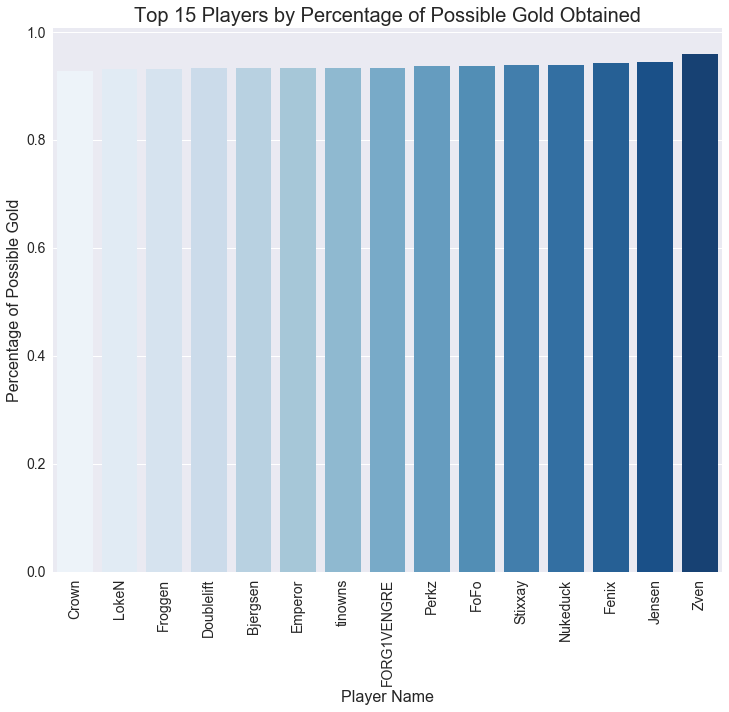

In [82]:
# create and format plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(x='player_name',y='pct_of_gold', palette='Blues', data=egb_plot);
plt.title("Top 15 Players by Percentage of Possible Gold Obtained",fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel("Player Name", fontsize=16)
plt.ylabel("Percentage of Possible Gold", fontsize=16);

The most surprising result of this graph is that most of these players are from Europe or the US. Generally, South Korea and China are regarded as the best regions, but at least in terms of farming Western players are generally more consistent. A possible reason for this might be that the Asian regions are more aggressive then their Western counterparts, thus leading to fewer opportunities to farm in the early game.

The other notable take-away here is the concentration of ADC and Mid players. These two roles are the most likely to spend the early game farming (and ADC even has a Support to ensure that he can farm unimpeded). 

As a brief aside, no list of effecient farmers would be complete without Froggen. This Mid-lane player is notorious for farming at the expense of other actions he could take. Sure enough he shows up here.

## HELPER FUNCTIONS

In [ ]:
def transform_df(df):
    # prepare data for graphing
    df = df.drop(['match_id', 'league', 'season', 'year', 'red_or_blue_side', 'result', 'game_length', 'type', 
            'player_name', 'champion'], axis=1)
    df = df.fillna(0)
    #transpose data
    df = df.drop('team_name', axis=1)
    df = df.T
    return df  

def format_time(df, time):
    # append to datafram
    df['time'] = time
    df['time_m'] = df['time'].dt.time
    # set as index
    df = df.set_index('time_m')
    df = df.drop('time',axis=1)
    return df

def seconds(row):
    return row * 60

def size_points(df):
    pt = df.pivot_table(index='time', values='seconds', aggfunc='count')
    pt.reset_index(inplace=True)
    df = pd.merge(df, pt, how='left', on='time')
    df.rename(columns={'seconds_y':'count'},inplace=True)
    df['count'] = df['count'] * 80
    return df

def gold_diff_df(df):
    df = df.loc[(df['SKT'] != 0),:]
    df.reset_index(drop=True,inplace=True)
    df.reset_index(inplace=True)
    return df

def stem_data(df,df2):
    df = df.T
    df.rename(columns={list(df.iloc[1:].columns.values)[0]:'time'},inplace=True)
    df = pd.merge(df,df2, how='inner',left_on='time', right_index=True)
    return df

def kda_ratio(df):
    df = pd.pivot_table(df, index=['player'], values= 'kda_ratio', aggfunc='count').reset_index().sort_values(by='kda_ratio')

    # average kda_ratio
    df2 = pd.pivot_table(df, index=['player'], values= 'kda_ratio', aggfunc=np.mean).reset_index().sort_values(by='kda_ratio')

    # create dataframe with top 20 players
    df3 = pd.merge(df2, df, on='player')
    df3 = df3.loc[df3['kda_ratio_y'] >= 40,:]
    df3 = df3.sort_values(by='kda_ratio_x')
    return (df3.tail(20))